In [1]:
#Libraries for EDA
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#Libraries for Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Machine Learning Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, auc
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

In [191]:
#Reading the dataset 
sample=pd.read_csv('sample_submission.csv', delimiter=',')
train=pd.read_csv('train.csv', delimiter=',')
test=pd.read_csv('test.csv', delimiter=',')
train.head()

,traveller_ID,ticket_class,name,sex,age,Siblings_spouses,Parchil,TickNum,fare,cabin,embarked,MedBoat,Survived
0,1214,3,"Smiljanic, Mr. Mile",male,NaN,0,0,315037,8.6625,NaN,S,NaN,0
1,677,3,"Bostandyeff, Mr. Guentcho",male,26.0,0,0,349224,7.8958,NaN,S,NaN,0
2,534,2,"Phillips, Miss. Kate Florence (""Mrs Kate Louis...",female,19.0,0,0,250655,26.0000,NaN,S,11,1
3,1174,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S,NaN,0
4,864,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,NaN,S,NaN,0


In [192]:
#The shape of the train and test dataset
print('This is the shape of the Train dataset:', train.shape)
print('This is the shape of the Test dataset:', test.shape)

This is the shape of the Train dataset: (916, 13)
This is the shape of the Test dataset: (393, 12)


In [193]:
#Checking the column to be predicted
for target in train.columns:
    if target not in test.columns:
        print(target)

Survived


In [194]:
#Info about the dataset
print('The Train Info of the Dataset')
print(train.info())
print('')
print('+'*60)
print('')
print('The Test Info of the Dataset')
print(test.info())

The Train Info of the Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 13 columns):
traveller_ID        916 non-null int64
ticket_class        916 non-null int64
name                916 non-null object
sex                 916 non-null object
age                 729 non-null float64
Siblings_spouses    916 non-null int64
Parchil             916 non-null int64
TickNum             916 non-null object
fare                915 non-null float64
cabin               204 non-null object
embarked            915 non-null object
MedBoat             327 non-null object
Survived            916 non-null int64
dtypes: float64(2), int64(5), object(6)
memory usage: 93.2+ KB
None

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

The Test Info of the Dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 12 columns):
traveller_ID        393 non-null int64
ticket_class        393 non-null float64
nam

In [196]:
#Creating a new column name Title from the name column 
test['Title'] = test.name.str.extract(' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Title'].replace(['Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Title')
test['Title'] = test['Title'].replace('Mlle', 'Miss')
test['Title'] = test['Title'].replace('Ms', 'Miss')
test['Title'] = test['Title'].replace(['Mme','Lady'], 'Mrs')

train['Title'] = train.name.str.extract(' ([A-Za-z]+)\.', expand=False)
train['Title'] = train['Title'].replace(['Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Title')
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace(['Mme','Lady'], 'Mrs')

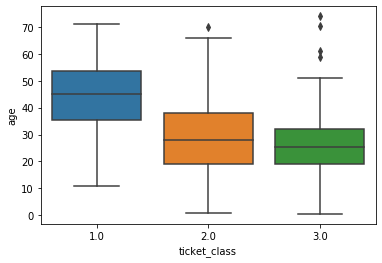

In [197]:
#A boxplot which shows the outliers present in each of the ticket class before filling the Nan values with either mean or median
sns.boxplot(x='ticket_class', y='age', data=test);

In [198]:
test[test.ticket_class==3]['age'].mean()

26.031103521126763

In [203]:
#filling the empty value in the age column
train.age=train.age.fillna(train.age.mean())

In [204]:
#filling the empty value in the age column
test.age=test.age.fillna(test.age.mean())

In [205]:
##filling the empty value in the fare column with the mode since it does not give a Gaussian curve from the kde plot
train.fare=train.fare.fillna((train.fare.mode()[0]+train.fare.mode()[1])/2)

In [206]:
test.fare=test.fare.fillna(test.fare.mode())

In [207]:
#filling the empty value in the embarked  column
train.embarked=train.embarked.fillna(value='S')
test.embarked=test.embarked.fillna(value='S')

In [208]:
train['MedBoat']=train['MedBoat'].isnull()

In [209]:
test['MedBoat']=test['MedBoat'].isnull()

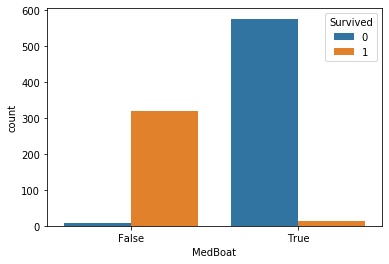

In [210]:
#A countplot showing the effect of MedBoat to people that survived
'''
From thi countplot we could say that people on the MedBoat Column
tends to survive than people not on the MedBoat

'''
sns.countplot(train['MedBoat'], hue=train['Survived'])

In [212]:
train_object=train.select_dtypes(include='object')
test_object=test.select_dtypes(include='object')

In [216]:
train_num = train.drop(labels=['name', 'sex', 'TickNum', 'embarked',], axis=1)
test_num = test.drop(labels=['name', 'sex', 'TickNum', 'embarked'], axis=1)

In [217]:
#Checking the correlation between the Numeric features to the survived column
train_num_corr=train.corr()
train_num_corr

,traveller_ID,ticket_class,age,Siblings_spouses,Parchil,fare,MedBoat,Survived
traveller_ID,1.000000,0.899047,-0.291545,0.070936,0.032266,-0.477730,0.312347,-0.303913
ticket_class,0.899047,1.000000,-0.344777,0.061178,0.038908,-0.555610,0.327582,-0.316505
age,-0.291545,-0.344777,1.000000,-0.193653,-0.145755,0.130694,0.009243,-0.013503
Siblings_spouses,0.070936,0.061178,-0.193653,1.000000,0.367258,0.158166,0.019701,-0.013675
Parchil,0.032266,0.038908,-0.145755,0.367258,1.000000,0.215006,-0.070458,0.071425
fare,-0.477730,-0.555610,0.130694,0.158166,0.215006,1.000000,-0.269031,0.262098
MedBoat,0.312347,0.327582,0.009243,0.019701,-0.070458,-0.269031,1.000000,-0.952613
Survived,-0.303913,-0.316505,-0.013503,-0.013675,0.071425,0.262098,-0.952613,1.000000


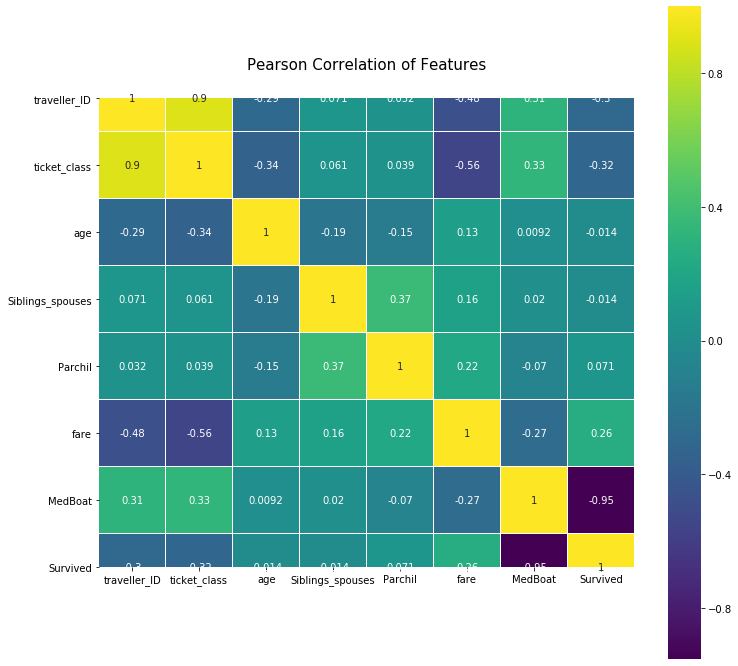

In [218]:
#A Heatmap showing the correlation of the numerical features
colormap = plt.cm.viridis
plt.figure(figsize=(12,12));
plt.title(' Correlation of Features', y=1.05, size=15);
sns.heatmap(train_num_corr,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True);

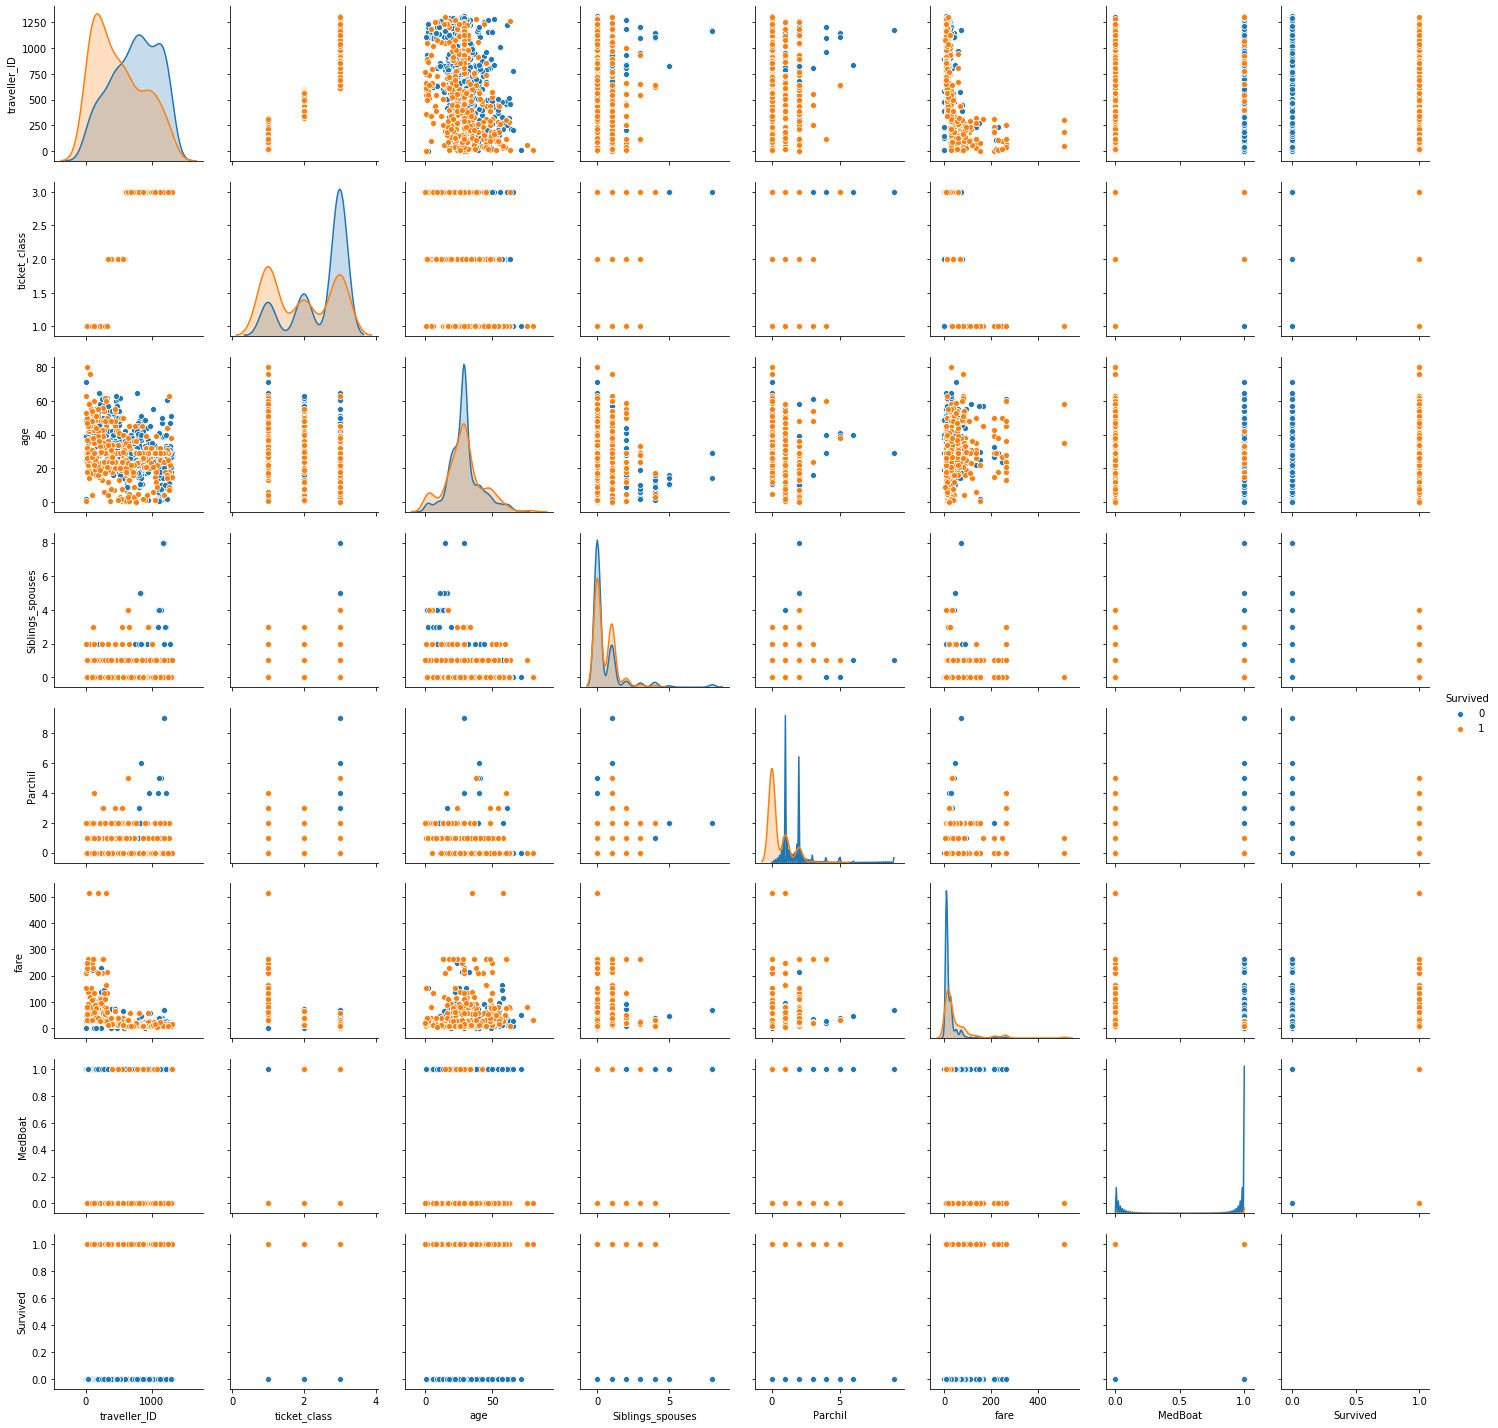

In [219]:
sns.pairplot(train, hue='Survived');

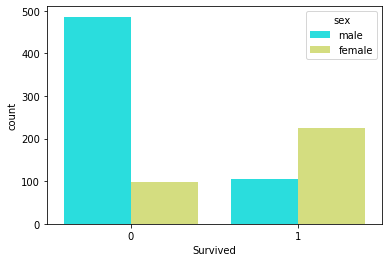

In [220]:
#A countplot of the Gender to the Survived column
'''
From this graph we can imply that Female tends to survive that male 
'''
sns.countplot(train.Survived, hue=train.sex,palette='rainbow' ,saturation=1)

In [221]:
train_num_drop =train_num.drop(['traveller_ID', 'Survived'], axis=1)
test_num
train_num_drop

,ticket_class,age,Siblings_spouses,Parchil,fare,cabin,MedBoat,Title
0,3,29.102309,0,0,8.6625,NaN,True,Mr
1,3,26.000000,0,0,7.8958,NaN,True,Mr
2,2,19.000000,0,0,26.0000,NaN,False,Miss
3,3,29.102309,8,2,69.5500,NaN,True,Miss
4,3,28.000000,0,0,7.7750,NaN,True,Miss
...,...,...,...,...,...,...,...,...
911,3,29.102309,0,0,7.6292,NaN,True,Miss
912,3,18.000000,0,0,7.7750,NaN,True,Miss
913,3,28.500000,0,0,16.1000,NaN,True,Mr
914,3,26.000000,0,0,7.9250,NaN,True,Miss


In [222]:
le=LabelEncoder()

In [224]:
#Creating new column from the categorical column using pandas built in function get_dummies 
train_num[[ 'Male']]=pd.get_dummies(train.sex, drop_first=True).astype('int64')
test_num[[ 'Male']]=pd.get_dummies(test.sex,drop_first=True).astype('int64')

train_num[['S','Q']]=pd.get_dummies(train.embarked,drop_first=True).astype('int64')
test_num[['S','Q']]=pd.get_dummies(test.embarked,drop_first=True).astype('int64')

train_num[[2,1]]=pd.get_dummies(train.ticket_class,drop_first=True).astype('int64')
test_num[[2,1]]=pd.get_dummies(test.ticket_class,drop_first=True).astype('int64')

In [225]:
#Converting the Title Column to an Integer using the LabelEncoder
train.Title=le.fit_transform(train.Title).astype('int64')
test.Title=le.transform(test.Title).astype('int64')
test_num['Title']=test.Title
train_num['Title']=train.Title

In [226]:
#Converting the MedBoat Column to an Integer using the LabelEncoder
train.MedBoat=le.fit_transform(train.MedBoat).astype('int64')
test.MedBoat=le.transform(test.MedBoat).astype('int64')
test_num['MedBoat']=test.MedBoat
train_num['MedBoat']=train.MedBoat

In [227]:
train.Title.value_counts()

2    530
1    187
3    135
0     41
4     23
Name: Title, dtype: int64

## Machine Learning Algorithm

In [234]:
#assigniong pur Numerical Feature to our Dependent and Independent Variables for prediction
X = train_num[['age','Siblings_spouses','Parchil','fare','MedBoat','Title','Male','S','Q',2,1]]
y=train['Survived']
X.head(1)

,age,Siblings_spouses,Parchil,fare,MedBoat,Title,Male,S,Q,2,1
0,29.102309,0,0,8.6625,1,2,1,0,1,0,1


In [235]:
test_num=test_num.drop(labels=['ticket_class'], axis=1)
test_num=test_num.drop(labels=['traveller_ID'], axis=1)
test_num=test_num.drop(labels=['cabin'], axis=1)

In [238]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=101,shuffle=True)

In [239]:
print(X_train.shape)
print(y_train.shape)

(641, 11)
(641,)


In [240]:
sc_X=StandardScaler()

In [241]:
col=X_train.columns

In [242]:
#Scaling our dataset beforoe fitting into our Algorithm
X =sc_X.fit_transform(X_train)
y=sc_X.transform(test_num)
y=pd.DataFrame(test_num, columns=col)
X=pd.DataFrame(X, columns=col)

In [243]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 641 entries, 424 to 863
Data columns (total 11 columns):
age                 641 non-null float64
Siblings_spouses    641 non-null int64
Parchil             641 non-null int64
fare                641 non-null float64
MedBoat             641 non-null int64
Title               641 non-null int64
Male                641 non-null int64
S                   641 non-null int64
Q                   641 non-null int64
2                   641 non-null int64
1                   641 non-null int64
dtypes: float64(2), int64(9)
memory usage: 60.1 KB


Accuracy:  97.0909090909091
Precision:  97.87234042553192
Recall:  93.87755102040816
ROC AUC 96.37380375879167
F1 Score for Training dataset: 97.42489270386267
F1 Score for Testing dataset: 95.83333333333333


<Figure size 216x144 with 0 Axes>

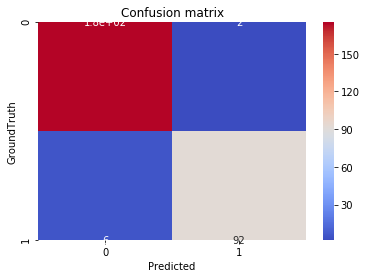

<Figure size 216x144 with 0 Axes>

In [260]:
'''
Using Random Forest Classifier for the prediction and passing
our Dependent and Independet variable into our Machine Learning Algorithm

'''
classifier = RandomForestClassifier(min_samples_leaf=5,max_features='auto',n_estimators = 50, criterion = 'entropy', random_state =42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print("Accuracy: ", metrics.accuracy_score(y_test, y_pred)*100)
print("Precision: ", metrics.precision_score(y_test, y_pred)*100)
print("Recall: ", metrics.recall_score(y_test, y_pred)*100)
fpr, tpr, thresholds = roc_curve (y_test, y_pred)
roc_auc= auc (fpr, tpr)
print  ("ROC AUC", roc_auc*100)

#Random Forest Algorithm
submission_file=sample
from sklearn.metrics import f1_score
pred2=classifier.predict(X_train)
pred3=classifier.predict(X_test)
print('F1 Score for Training dataset:', f1_score(y_train, pred2)*100)
print('F1 Score for Testing dataset:', f1_score(y_test, pred3)*100)

#Confusion Matrix
plt.title('Confusion matrix')
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), annot=True, cmap='coolwarm');
plt.ylabel('GroundTruth');
plt.xlabel('Predicted');
plt.figure(figsize=(3,2))

This is the shape of the dataset: (393, 2)
This is the amount of people that did not Survived: 234
This is the amount of people that did Survived: 159


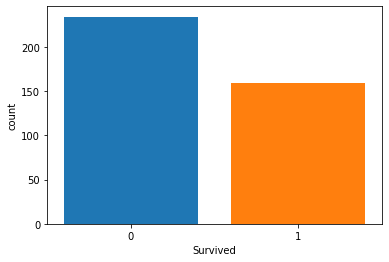

In [261]:
#Passing our Prediction into our a csv file for submission
newrf=sample.copy()
newrf.Survived =classifier.predict(y)
newrf.to_csv('newrf.csv', index=False)
newrf=pd.read_csv('newrf.csv', delimiter=',')
print('This is the shape of the dataset:',newrf.shape)
print('This is the amount of people that did not Survived:',newrf.Survived.value_counts()[0])
print('This is the amount of people that did Survived:',newrf.Survived.value_counts()[1])
sns.countplot(newrf.Survived, saturation=1);